In [80]:
import sys
import os
from os import sep
from os.path import dirname, realpath, splitext
from pathlib import Path
from functools import partial, reduce
from itertools import product
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which sis why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fix_path(get_cwd('inspect_report_corr.ipynb', 'recon' +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dask import delayed, compute
from sortedcontainers import SortedList, SortedSet 

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option('display.max_rows', 500)
# pd.set_option('display.height', 500)
pd.set_option('display.max_columns', 50)

from common_util import DT_HOURLY_FREQ, DT_CAL_DAILY_FREQ, DT_BIZ_DAILY_FREQ, list_get_dict, inner_join, right_join, get_custom_biz_freq_df, query_df, search_df, chained_filter, recursive_dict, benchmark
from common_util import RECON_DIR, set_loglevel, load_json, df_count, df_value_count, outer_join, left_join, getcon, string_df_join_to_ser, is_df, is_ser, count_nn_nz_df, pairwise, cust_count, get_pardir_from_path
from recon.common import REPORT_DIR, DATASET_DIR
from recon.dataset_util import prep_dataset, gen_group
from recon.split_util import get_train_test_split, gen_time_series_split, index_three_split
from recon.viz import *

In [81]:
set_loglevel('info')

In [82]:
os.listdir(DATASET_DIR)

['mvp_targets_eod2.json',
 'mvp_dnorm_raw.json',
 'mvp_targets_fbxeod1_log.json',
 'drl.json',
 'mvp_labels.json',
 'mvp_labels_fbxeod2.json',
 'dnorm_raw_pba_ohlca.json',
 'drl_raw_trmi_buzzless.json',
 'dnorm_dmx_raw_pba_avgprice.json',
 'mvp_targets.json',
 'mvp_targets_eod1_lin.json',
 'mvp_labels_fbxeod1_lin.json',
 'dma.json',
 'mvp_labels_fbxeod1_log.json',
 'dnorm_raw.json',
 'mvp_labels_eod1_log.json',
 'mvp_targets_eod1_log.json',
 'raw_pba_ohlca.json',
 'row_masks.json',
 'mvp_labels_eod2.json',
 'ddiff.json',
 'dnorm_sym.json',
 'mvp_targets_fbxeod2.json',
 'mvp_labels_eod1_lin.json',
 'sym_raw.json',
 'mvp_targets_fbxeod1_lin.json',
 'xg0_reteod_direod.json',
 'dnorm_dmx_raw_pba_ohlca.json']

In [83]:
dataset_name = 'raw_pba_ohlca.json'
assets_str = 'sp_500,russell_2000,nasdaq_100,dow_jones'
all_assets = list(map(str.strip, assets_str.split(',')))

dataset_dict = load_json(dataset_name, dir_path=DATASET_DIR)

In [84]:
dataset_dict['labels'] = 'mvp_labels.json'
dataset_dict['targets'] = 'mvp_targets.json'
logging.info(dataset_dict)

INFO:root:{'features': [['raw', 'raw_pba_ohlca']], 'labels': 'mvp_labels.json', 'targets': 'mvp_targets.json', 'row_masks': 'row_masks.json'}


In [85]:
dataset = prep_dataset(dataset_dict, assets=all_assets)

logging.info('dataset: {} {} df(s)'.format(len(dataset['features']), dataset_name))
logging.info('assets: {}'.format(str('all' if (all_assets==None) else ', '.join(all_assets))))
logging.debug('fpaths: {}'.format(str(list(dataset['features']['dfs'].keys()))))
logging.debug('lpaths: {}'.format(str(list(dataset['labels']['dfs'].keys()))))

INFO:root:dataset: 2 raw_pba_ohlca.json df(s)
INFO:root:assets: sp_500, russell_2000, nasdaq_100, dow_jones


In [86]:
list(dataset['features']['dfs'].keys())

[['dow_jones', 'raw_pba_ohlca', 'raw_pba'],
 ['nasdaq_100', 'raw_pba_ohlca', 'raw_pba'],
 ['russell_2000', 'raw_pba_ohlca', 'raw_pba'],
 ['sp_500', 'raw_pba_ohlca', 'raw_pba']]

In [87]:
date_range = {
    'id': ('gt', 2009)
}

In [88]:
FMT = '{pfx}_{s}'
fdfs = [dataset['features']['dfs'][k].dropna(axis=0).rename(columns=lambda s: FMT.format(pfx=k[0], s=s)).compute() for k in dataset['features']['dfs'].keys()]
ldfs = [dataset['labels']['dfs'][k].dropna(axis=0).rename(columns=lambda s: FMT.format(pfx=k[0], s=s)).compute() for k in dataset['labels']['dfs'].keys()]
rdfs = [dataset['targets']['dfs'][k].dropna(axis=0).rename(columns=lambda s: FMT.format(pfx=k[0], s=s)).compute() for k in dataset['targets']['dfs'].keys()]

In [89]:
fdf_all = reduce(inner_join, fdfs)
ldf_all = reduce(inner_join, ldfs)
rdf_all = reduce(inner_join, rdfs)

In [90]:
fdf = fdf_all.loc[search_df(fdf_all, date_range)]
ldf = ldf_all.loc[search_df(ldf_all, date_range)]
rdf = rdf_all.loc[search_df(rdf_all, date_range)]

In [91]:
def plot_df(df, title='plot', xlabel='xlab', ylabel='ylab'):
	plt.figure(figsize=((25, 10)))
	plt.title(title)
# 	plt.xaxis.set_major_locator(mdates.YearLocator(1))
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	[plt.plot(df.index, df.loc[:, col_name], '-', label=str(col_name)) for col_name in df.columns]
	plt.legend(loc='upper left')
	plt.show()

In [105]:
assets = all_assets

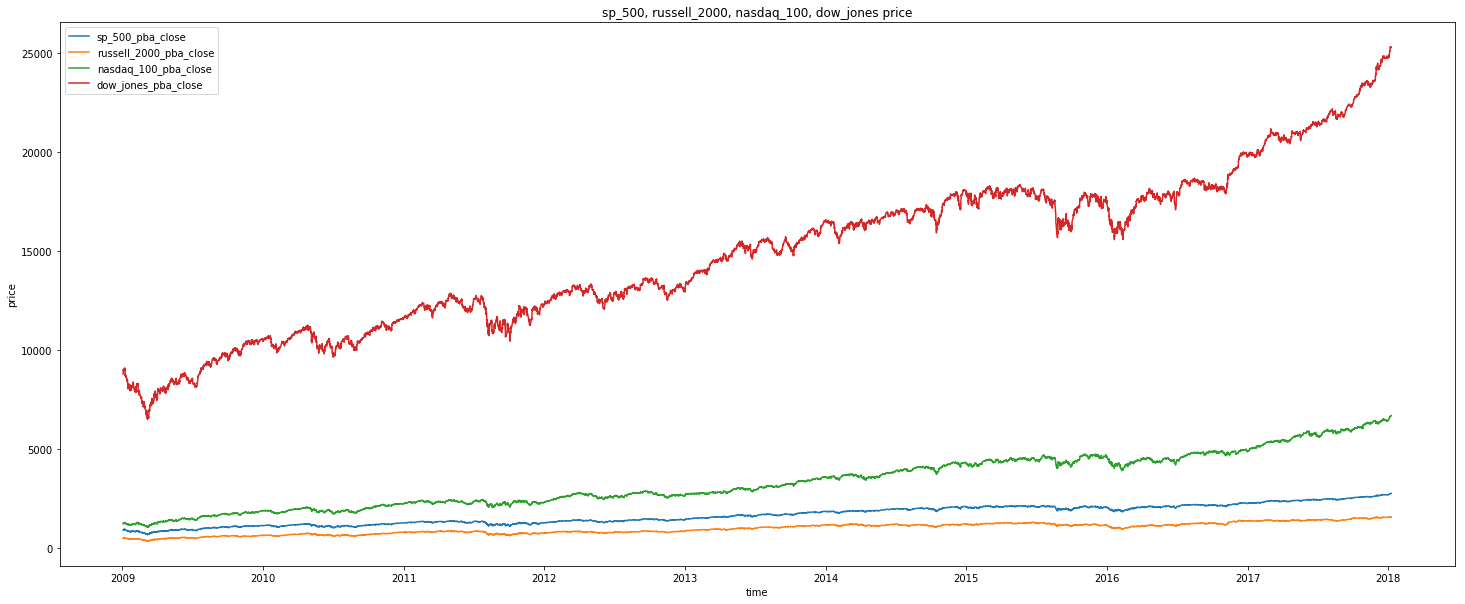

In [112]:
plot_df(fdf.loc[:, ['{}_pba_close'.format(asset) for asset in assets]], title='{} price'.format(', '.join(assets)), xlabel='time', ylabel='price')

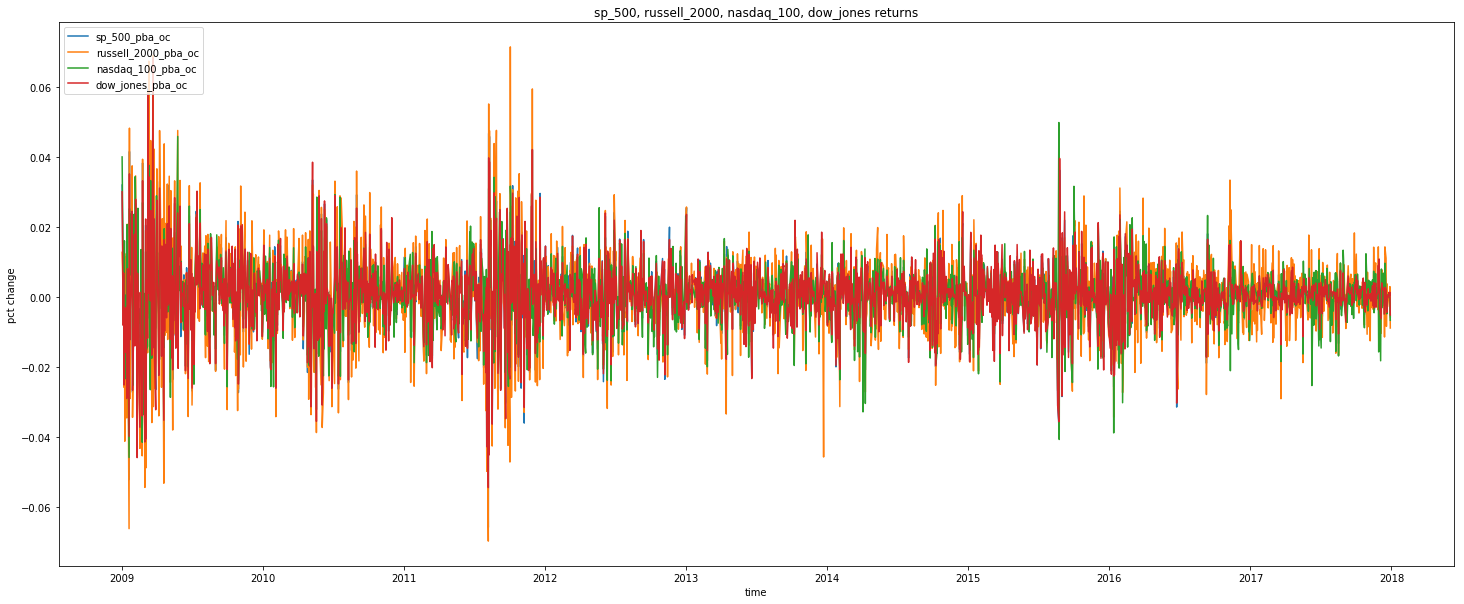

In [113]:
plot_df(rdf.loc[:, ['{}_pba_oc'.format(asset) for asset in assets]], title='{} returns'.format(', '.join(assets)), xlabel='time', ylabel='pct change')

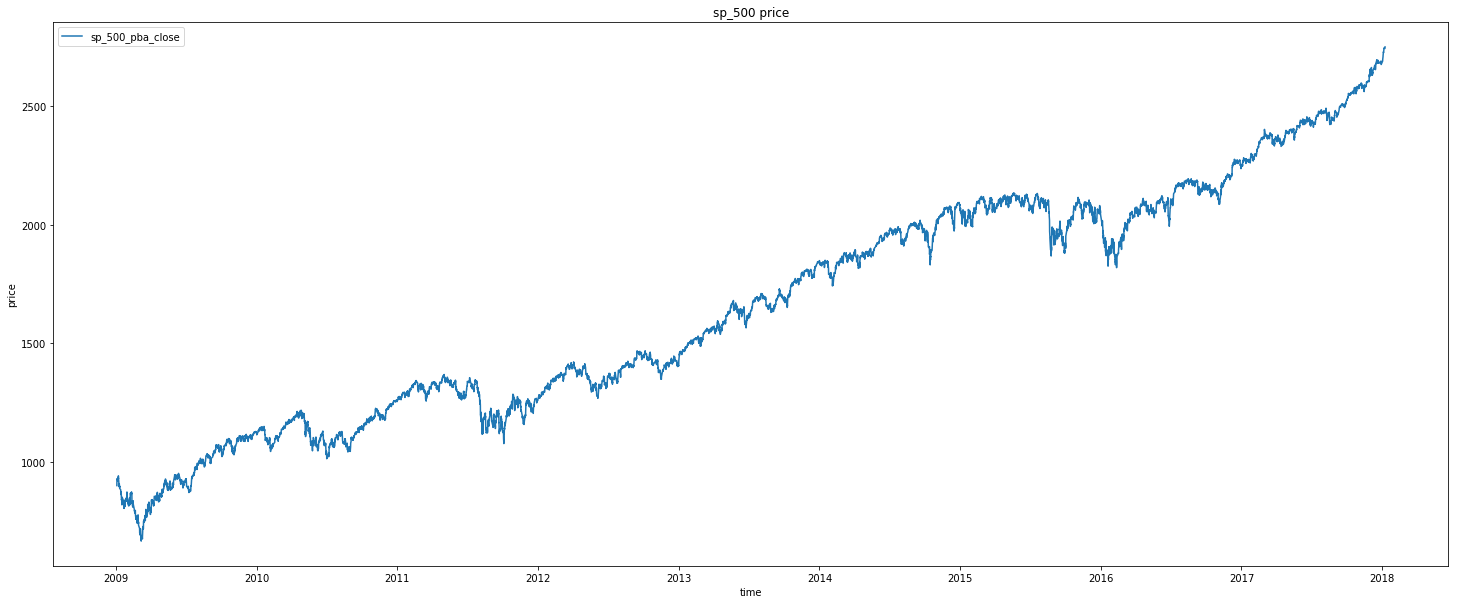

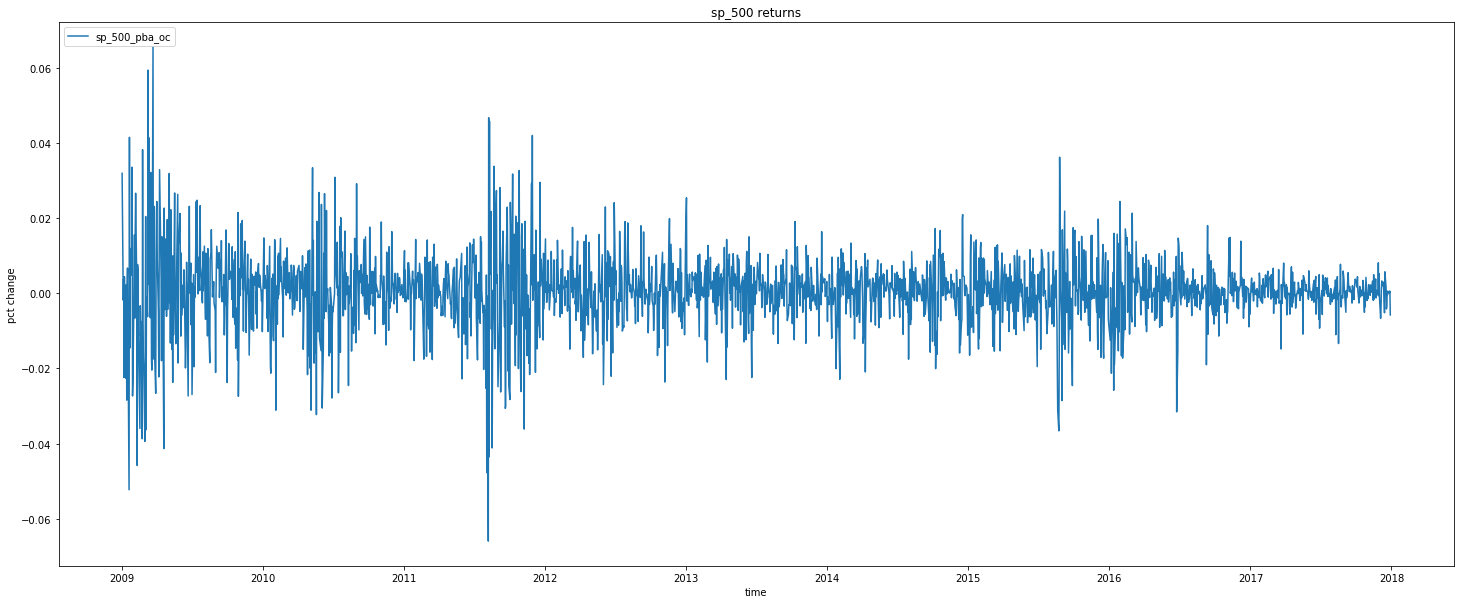

In [118]:
assets = ['sp_500']
plot_df(fdf.loc[:, ['{}_pba_close'.format(asset) for asset in assets]], title='{} price'.format(', '.join(assets)), xlabel='time', ylabel='price')
plot_df(rdf.loc[:, ['{}_pba_oc'.format(asset) for asset in assets]], title='{} returns'.format(', '.join(assets)), xlabel='time', ylabel='pct change')

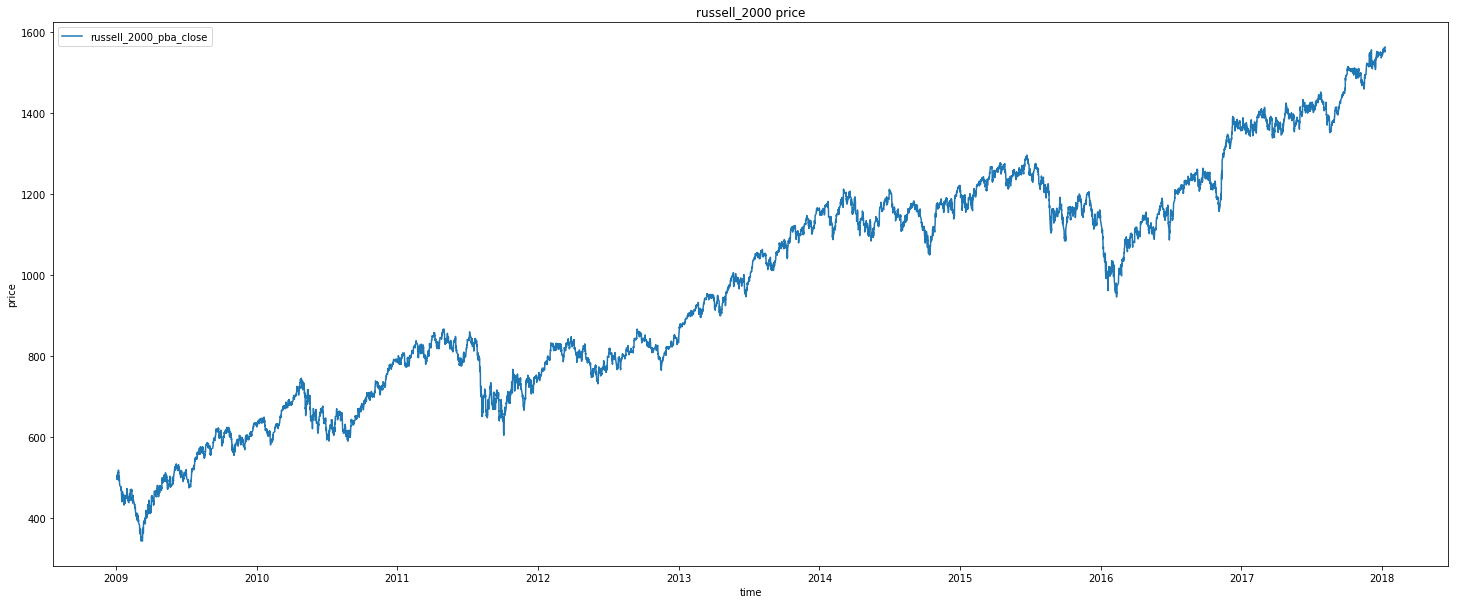

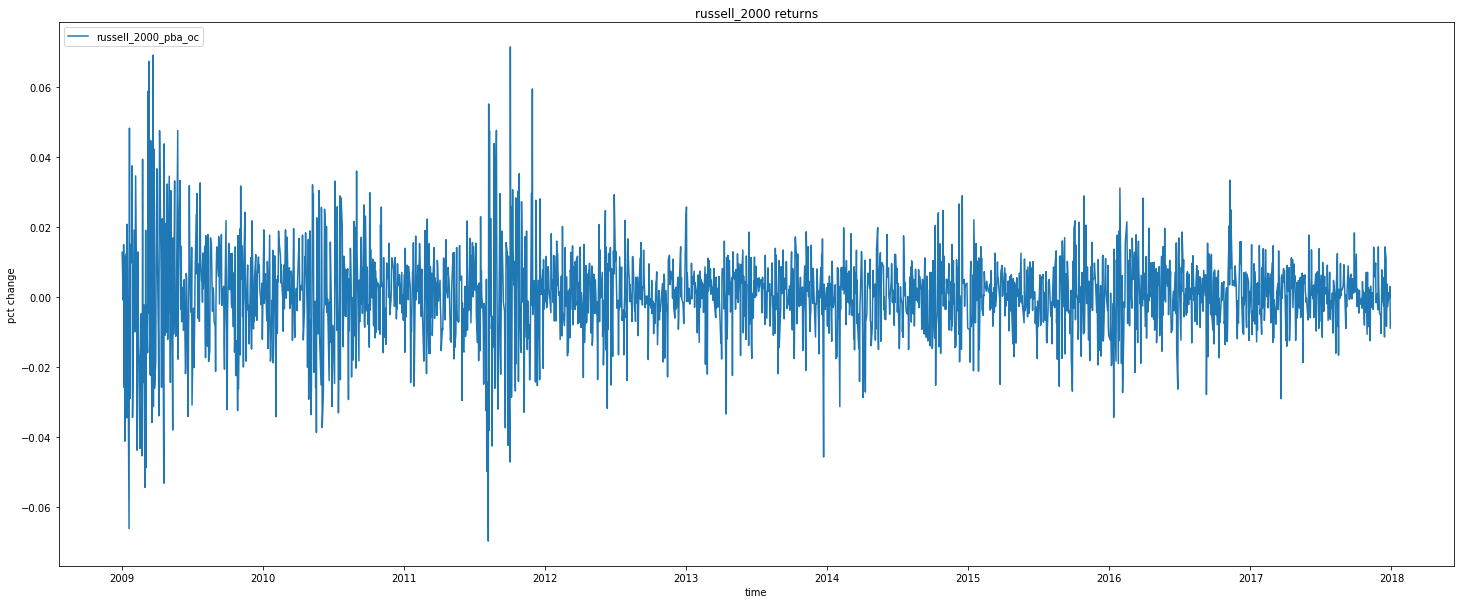

In [119]:
assets = ['russell_2000']
plot_df(fdf.loc[:, ['{}_pba_close'.format(asset) for asset in assets]], title='{} price'.format(', '.join(assets)), xlabel='time', ylabel='price')
plot_df(rdf.loc[:, ['{}_pba_oc'.format(asset) for asset in assets]], title='{} returns'.format(', '.join(assets)), xlabel='time', ylabel='pct change')

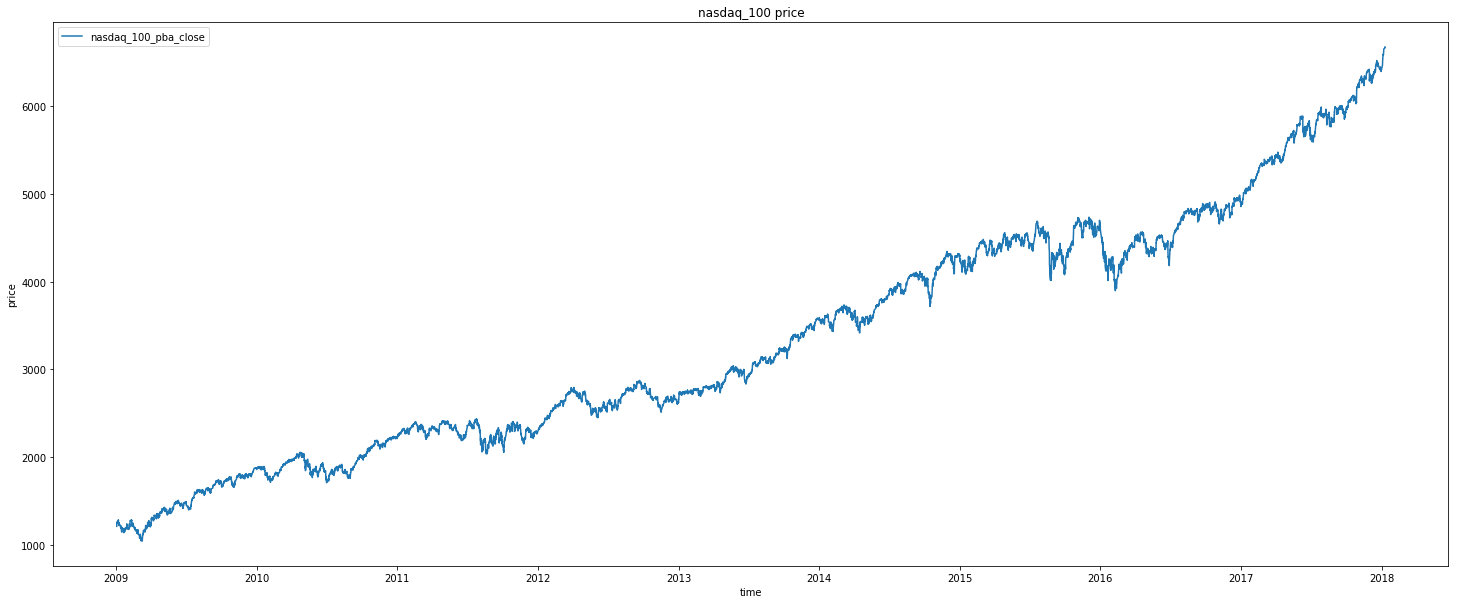

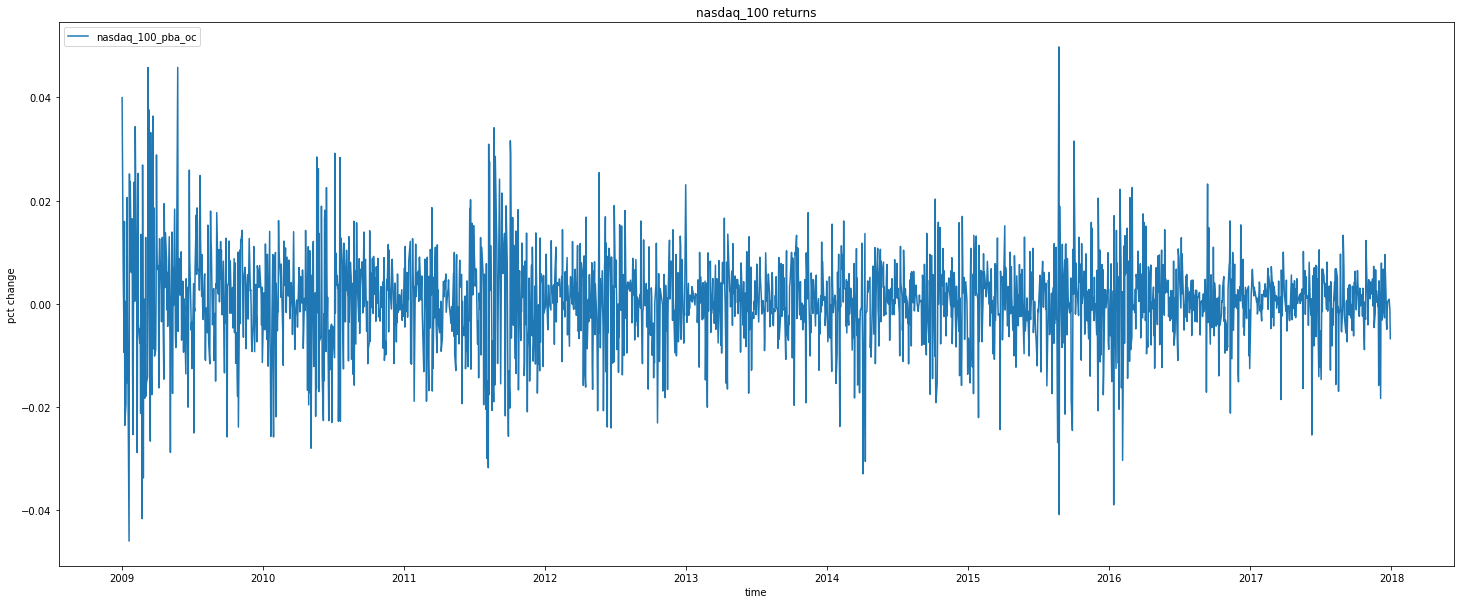

In [120]:
assets = ['nasdaq_100']
plot_df(fdf.loc[:, ['{}_pba_close'.format(asset) for asset in assets]], title='{} price'.format(', '.join(assets)), xlabel='time', ylabel='price')
plot_df(rdf.loc[:, ['{}_pba_oc'.format(asset) for asset in assets]], title='{} returns'.format(', '.join(assets)), xlabel='time', ylabel='pct change')

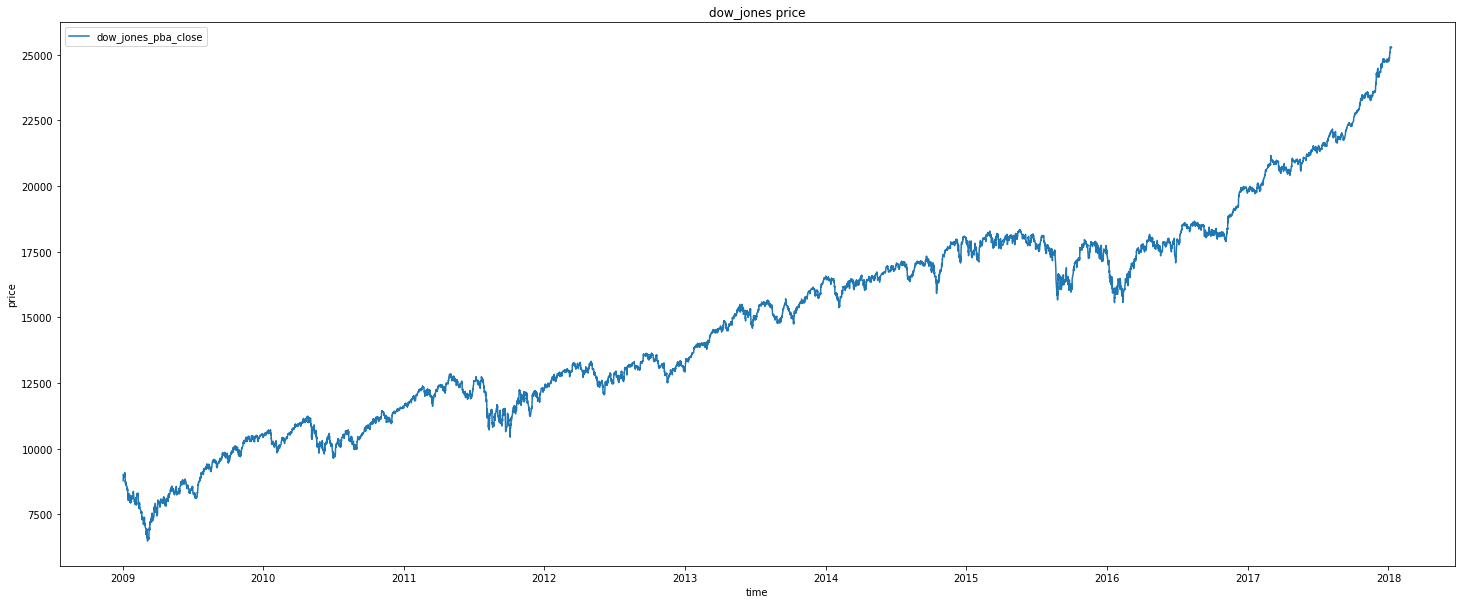

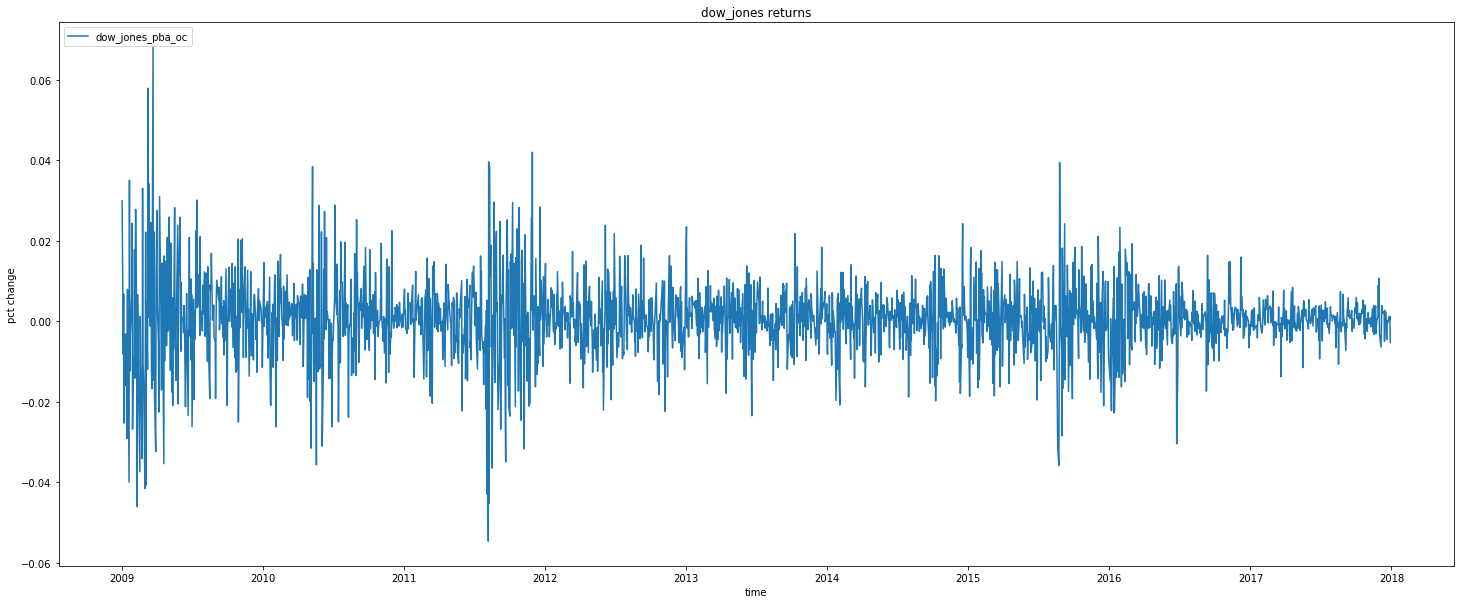

In [121]:
assets = ['dow_jones']
plot_df(fdf.loc[:, ['{}_pba_close'.format(asset) for asset in assets]], title='{} price'.format(', '.join(assets)), xlabel='time', ylabel='price')
plot_df(rdf.loc[:, ['{}_pba_oc'.format(asset) for asset in assets]], title='{} returns'.format(', '.join(assets)), xlabel='time', ylabel='pct change')

## Correlation Matrices

In [51]:
rdf_all.corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.612669,0.780216,0.712644
nasdaq_100_pba_oc,0.612669,1.000000,0.707331,0.540111
russell_2000_pba_oc,0.780216,0.707331,1.000000,0.632584
sp_500_pba_oc,0.712644,0.540111,0.632584,1.000000


In [52]:
rdf_all.loc[search_df(rdf_all, {'id': ('gt', 2000)})].corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.603390,0.786908,0.696221
nasdaq_100_pba_oc,0.603390,1.000000,0.713151,0.515055
russell_2000_pba_oc,0.786908,0.713151,1.000000,0.623033
sp_500_pba_oc,0.696221,0.515055,0.623033,1.000000


In [53]:
rdf_all.loc[search_df(rdf_all, {'id': ('gt', 2006)})].corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.710319,0.822177,0.974669
nasdaq_100_pba_oc,0.710319,1.000000,0.806405,0.784755
russell_2000_pba_oc,0.822177,0.806405,1.000000,0.879087
sp_500_pba_oc,0.974669,0.784755,0.879087,1.000000


In [54]:
rdf_all.loc[search_df(rdf_all, {'id': ('gt', 2008)})].corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.710122,0.822852,0.975061
nasdaq_100_pba_oc,0.710122,1.000000,0.809469,0.788463
russell_2000_pba_oc,0.822852,0.809469,1.000000,0.880370
sp_500_pba_oc,0.975061,0.788463,0.880370,1.000000


In [55]:
rdf_all.loc[search_df(rdf_all, {'id': ('gt', 2009)})].corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.657497,0.798725,0.968928
nasdaq_100_pba_oc,0.657497,1.000000,0.772272,0.749737
russell_2000_pba_oc,0.798725,0.772272,1.000000,0.866108
sp_500_pba_oc,0.968928,0.749737,0.866108,1.000000


In [56]:
rdf_all.loc[search_df(rdf_all, {'id': ('gt', 2010)})].corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.627211,0.759862,0.966424
nasdaq_100_pba_oc,0.627211,1.000000,0.755756,0.728070
russell_2000_pba_oc,0.759862,0.755756,1.000000,0.836068
sp_500_pba_oc,0.966424,0.728070,0.836068,1.000000


In [57]:
rdf_all.loc[search_df(rdf_all, {'id': ('ine', 1998, 2006)})].corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.602004,0.715537,0.537209
nasdaq_100_pba_oc,0.602004,1.000000,0.722604,0.436861
russell_2000_pba_oc,0.715537,0.722604,1.000000,0.463578
sp_500_pba_oc,0.537209,0.436861,0.463578,1.000000


In [58]:
rdf_all.loc[search_df(rdf_all, {'id': ('ine', 2006, 2012)})].corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.741570,0.857428,0.978733
nasdaq_100_pba_oc,0.741570,1.000000,0.833505,0.805637
russell_2000_pba_oc,0.857428,0.833505,1.000000,0.905696
sp_500_pba_oc,0.978733,0.805637,0.905696,1.000000


In [59]:
rdf_all.loc[search_df(rdf_all, {'id': ('ine', 2012, 2018)})].corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.602645,0.682497,0.958626
nasdaq_100_pba_oc,0.602645,1.000000,0.714128,0.714739
russell_2000_pba_oc,0.682497,0.714128,1.000000,0.769498
sp_500_pba_oc,0.958626,0.714739,0.769498,1.000000


In [60]:
rdf_all.loc[search_df(rdf_all, {'id': ('ine', 2006, 2018)})].corr()

,dow_jones_pba_oc,nasdaq_100_pba_oc,russell_2000_pba_oc,sp_500_pba_oc
dow_jones_pba_oc,1.000000,0.710319,0.822177,0.974669
nasdaq_100_pba_oc,0.710319,1.000000,0.806405,0.784755
russell_2000_pba_oc,0.822177,0.806405,1.000000,0.879087
sp_500_pba_oc,0.974669,0.784755,0.879087,1.000000


In [41]:
from ax import optimize
best_parameters, best_values, experiment, model = optimize(
        parameters=[
          {
            "name": "x1",
            "type": "range",
            "bounds": [-10.0, 10.0],
          },
          {
            "name": "x2",
            "type": "range",
            "bounds": [-10.0, 10.0],
          },
        ],
        # Booth function
        evaluation_function=lambda p: (p["x1"] + 2*p["x2"] - 7)**2 + (2*p["x1"] + p["x2"] - 5)**2,
        minimize=True,
    )


[INFO 05-05 13:59:19] ax.service.utils.dispatch: Using Bayesian Optimization generation strategy. Iterations after 5 will take longer to generate due to model-fitting.
[INFO 05-05 13:59:19] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 05-05 13:59:19] ax.service.managed_loop: Running optimization trial 1...
[INFO 05-05 13:59:19] ax.service.managed_loop: Running optimization trial 2...
[INFO 05-05 13:59:19] ax.service.managed_loop: Running optimization trial 3...
[INFO 05-05 13:59:19] ax.service.managed_loop: Running optimization trial 4...
[INFO 05-05 13:59:19] ax.service.managed_loop: Running optimization trial 5...
[INFO 05-05 13:59:19] ax.service.managed_loop: Running optimization trial 6...
[INFO 05-05 13:59:20] ax.service.managed_loop: Running optimization trial 7...
[INFO 05-05 13:59:21] ax.service.managed_loop: Running optimization trial 8...
[INFO 05-05 13:59:22] ax.service.managed_loop: Running optimization trial 9...
[INFO 05-05 13:59:23] ax.service.

In [42]:
best_parameters

{'x1': 0.9544861205887258, 'x2': 3.0253535338086817}